In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io

img_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256.png')
img_128 = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_128x128.png')
img_gray_128 = cv2.cvtColor(img_128, cv2.COLOR_RGB2GRAY)
img_noise = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_noise.png')
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_dark = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_dark.png')
img_dark_gray = cv2.cvtColor(img_dark, cv2.COLOR_RGB2GRAY)
img_light = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_light.png')
img_light_gray = cv2.cvtColor(img_light, cv2.COLOR_RGB2GRAY)

### Q.31. アフィン変換(スキュー)

Affine (skew)

(1)アフィン変換を用いて、X-sharing(dx = 30)画像を作成せよ。

(2)アフィン変換を用いて、Y-sharing(dy = 30)画像を作成せよ。

(3)アフィン変換を用いて、幾何変換した(dx = 30, dy = 30)画像を作成せよ。

このような画像はスキュー画像と呼ばれ、画像を斜め方向に伸ばした画像である。

出力(1)の場合、x方向にdxだけ引き伸ばした画像はX-sharingと呼ばれる。

出力(2)の場合、y方向にdyだけ引き伸ばした画像はY-sharingと呼ばれる。

それぞれ次式のアフィン変換で実現できる。 ただし、元画像のサイズがh x wとする。

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/affine_xysharing.png" width="200"/>

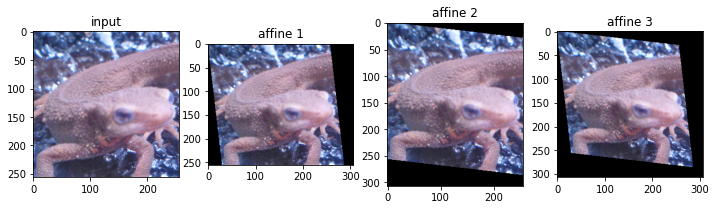

In [2]:
# answer
def affine(img, affine_mat, out_shape):
    h, w, channel = img.shape

    [a, b, tx], [c, d, ty] = affine_mat
    out_h, out_w = map(int, out_shape)
    
    out = np.zeros([out_h, out_w, channel])

    # pad for black
    img_pad = np.pad(img, [(1, 1), (1, 1), (0, 0)])
    
    xs, ys = np.meshgrid(range(out_w), range(out_h)) # output image index

    _xs = np.maximum(np.minimum((1 / (a * d - b * c) * (d * xs - b * ys) - tx).astype(int) + 1, w + 1), 0) # original image index x
    _ys = np.maximum(np.minimum((1 / (a * d - b * c) * (- c * xs + a * ys) - ty).astype(int) + 1, h + 1), 0) # original image index y

    out[ys, xs] = img_pad[_ys, _xs]
    return np.clip(out, 0, 255).astype(np.uint8)

h, w, c = img_orig.shape
img_affine_1 = affine(img_orig, [[1, 30 / h, 0], [0, 1, 0]], (h, w*1.2))
img_affine_2 = affine(img_orig, [[1, 0, 0], [30 / w, 1, 0]], (h * 1.2, w))
img_affine_3 = affine(img_orig, [[1, 30 / h, 0], [30 / w, 1, 0]], (h * 1.2, w*1.2))

plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1); plt.title('input'); plt.imshow(img_orig)
plt.subplot(1, 4, 2); plt.title('affine 1'); plt.imshow(img_affine_1)
plt.subplot(1, 4, 3); plt.title('affine 2'); plt.imshow(img_affine_2)
plt.subplot(1, 4, 4); plt.title('affine 3'); plt.imshow(img_affine_3)
plt.show()

### Q.32. フーリエ変換

二次元離散フーリエ変換(DFT)を実装し、グレースケールの周波数のパワースペクトルを表示せよ。 また、逆二次元離散フーリエ変換(IDFT)で画像を復元せよ。

二次元離散フーリエ変換(DFT: Discrete Fourier Transformation)とはフーリエ変換の画像に対する処理方法である。

通常のフーリエ変換はアナログ信号や音声などの連続値かつ一次元を対象に周波数成分を求める計算処理である。

一方、ディジタル画像は[0,255]の離散値をとり、かつ画像はHxWの二次元表示であるので、二次元離散フーリエ変換が行われる。

二次元離散フーリエ変換(DFT)は次式で計算される。

K = [0, W-1], l = [0, H-1], 入力画像を I として

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/dft.png" width="300"/>

ここではグレースケール画像から二次元離散フーリエ変換を行え。

パワースペクトル... Gは複素数で表されるので、Gの絶対値を求めることである。 今回のみ画像表示の時はパワースペクトルは[0,255]にスケーリングせよ。

逆二次元離散フーリエ変換(IDFT: Inverse DFT)とは周波数成分Gから元の画像を復元する手法であり、次式で定義される。

x = [0, W-1], y = [0, H-1] として

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/idft.png" width="300"/>

上が定義式ですがexp(j)は複素数の値をとってしまうので、実際にコードにするときはぜ下式のように絶対値を使います。

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/idft_abs.png" width="300"/>

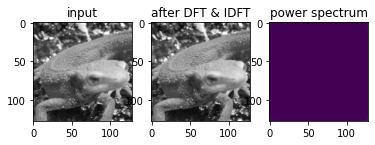

In [3]:
# DFT
def dft(img):
    H, W = img.shape
    G = np.zeros((H, W), dtype=complex)
    x, y = np.meshgrid(np.arange(0, W), np.arange(0, H))

    for l in range(H):
        for k in range(W):
            G[l, k] = np.sum(img * np.exp(-2j * np.pi * (x * k / W + y * l / H)))

    return G

# IDFT
def idft(G):
    H, W = G.shape
    out = np.zeros((H, W), dtype=np.float32)
    x, y = np.meshgrid(np.arange(0, W), np.arange(0, H))
    
    for l in range(H):
        for k in range(W):
            out[l, k] = np.abs(np.sum(G * np.exp(2j * np.pi * (x * k / W + y * l / H)))) / (H * W)

    # clipping
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    return out

# DFT
G = dft(img_gray_128)

# power spectrum
ps = (np.abs(G) / np.abs(G).max() * 255).astype(np.uint8)

# IDFT
out = idft(G)

plt.subplot(1, 3, 1)
plt.title("input")
plt.imshow(img_gray_128, cmap="gray")
plt.subplot(1, 3, 2)
plt.title("after DFT & IDFT")
plt.imshow(out, cmap="gray")
plt.subplot(1, 3, 3)
plt.title("power spectrum")
plt.imshow(ps)
plt.show()

### Q.33. フーリエ変換 ローパスフィルタ

ローパスフィルタを通してIDFTで画像を復元せよ。

DFTによって得られた周波数成分は左上、右上、左下、右下に近いほど低周波数の成分を含んでいることになり、中心に近いほど高周波成分を示す。

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_31_40/images/lpf.png"/>

画像における高周波成分とは色が変わっている部分（ノイズや輪郭など）を示し、低周波成分とは色があまり変わっていない部分（夕日のグラデーションなど）を表す。 ここでは、高周波成分をカットし、低周波成分のみを通すローパスフィルタを実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.5rまでの成分を通すとする。

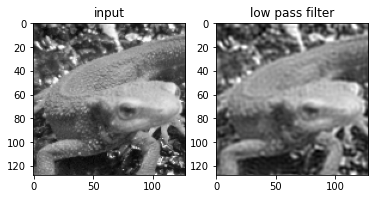

In [4]:
def lpf(G, ratio=0.5):
    H, W = G.shape
    h_half = H // 2
    w_half = W // 2
    
    # transfer positions
    _G = np.zeros_like(G)
    _G[:h_half, :w_half] = G[h_half:, w_half:]
    _G[:h_half, w_half:] = G[h_half:, :w_half]
    _G[h_half:, :w_half] = G[:h_half, w_half:]
    _G[h_half:, w_half:] = G[:h_half, :w_half]

    # filtering
    x, y = np.meshgrid(np.arange(0, W) - w_half, np.arange(0, H) - h_half)

    r = np.sqrt(x ** 2 + y ** 2)
    mask = np.ones((H, W), dtype=np.float32)
    mask[r > (h_half * ratio)] = 0
    _G *= mask

    # reverse original positions
    out = np.zeros_like(_G)
    out[:h_half, :w_half] = _G[h_half:, w_half:]
    out[:h_half, w_half:] = _G[h_half:, :w_half]
    out[h_half:, :w_half] = _G[:h_half, w_half:]
    out[h_half:, w_half:] = _G[:h_half, :w_half]

    return out


G_lpf = lpf(G)
out_lpf = idft(G_lpf)

plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_gray_128, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("low pass filter")
plt.imshow(out_lpf, cmap="gray")
plt.show()

### Q.34. フーリエ変換 ハイパスフィルタ

ハイパスフィルタを通してIDFTで画像を復元せよ。

ここでは、低周波成分をカットし、高周波成分のみを通すハイパスフィルタを実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.1rからの成分を通すとする。

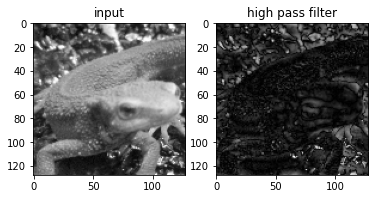

In [5]:
def hpf(G, ratio=0.1):
    H, W = G.shape
    h_half = H // 2
    w_half = W // 2
    
    # transfer positions
    _G = np.zeros_like(G)
    _G[:h_half, :w_half] = G[h_half:, w_half:]
    _G[:h_half, w_half:] = G[h_half:, :w_half]
    _G[h_half:, :w_half] = G[:h_half, w_half:]
    _G[h_half:, w_half:] = G[:h_half, :w_half]

    # filtering
    x, y = np.meshgrid(np.arange(0, W) - w_half, np.arange(0, H) - h_half)
    r = np.sqrt(x ** 2 + y ** 2)
    mask = np.ones((H, W), dtype=np.float32)
    mask[r < (h_half * ratio)] = 0
    _G *= mask

    # reverse original positions
    out = np.zeros_like(_G)
    out[:h_half, :w_half] = _G[h_half:, w_half:]
    out[:h_half, w_half:] = _G[h_half:, :w_half]
    out[h_half:, :w_half] = _G[:h_half, w_half:]
    out[h_half:, w_half:] = _G[:h_half, :w_half]

    return out


G_hpf = hpf(G)
out_hpf = idft(G_hpf)

plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_gray_128, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("high pass filter")
plt.imshow(out_hpf, cmap="gray")
plt.show()

### Q.35. フーリエ変換 バンドパスフィルタ

ハイパスフィルタを通してIDFTで画像を復元せよ。

ここでは、低周波成分と高周波成分の中間の周波数成分のみを通すハイパスフィルタを実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.1rから0.5rまでの成分を通すとする。

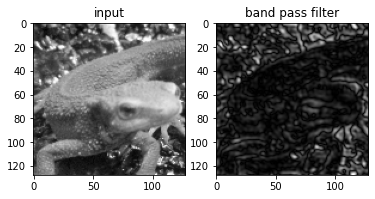

In [6]:
def bpf(G, low=0.1, high=0.5):
    H, W = G.shape
    h_half = H // 2
    w_half = W // 2
    
    # transfer positions
    _G = np.zeros_like(G)
    _G[:h_half, :w_half] = G[h_half:, w_half:]
    _G[:h_half, w_half:] = G[h_half:, :w_half]
    _G[h_half:, :w_half] = G[:h_half, w_half:]
    _G[h_half:, w_half:] = G[:h_half, :w_half]

    # filtering
    x, y = np.meshgrid(np.arange(0, W) - w_half, np.arange(0, H) - h_half)
    r = np.sqrt(x ** 2 + y ** 2)
    mask = np.ones((H, W), dtype=np.float32)
    mask[(r < (h_half * low)) | (r > (h_half * high))] = 0
    _G *= mask

    # reverse original positions
    out = np.zeros_like(_G)
    out[:h_half, :w_half] = _G[h_half:, w_half:]
    out[:h_half, w_half:] = _G[h_half:, :w_half]
    out[h_half:, :w_half] = _G[:h_half, w_half:]
    out[h_half:, w_half:] = _G[:h_half, :w_half]

    return out


G_bpf = bpf(G)
out_bpf = idft(G_bpf)

plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_gray_128, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("band pass filter")
plt.imshow(out_bpf, cmap="gray")
plt.show()

### Q.36. JPEG圧縮 (Step.1)離散コサイン変換

### Q.37. PSNR

### Q.38. JPEG圧縮 (Step.2)DCT+量子化

### Q.39. JPEG圧縮 (Step.3)YCbCr表色系

### Q.40. JPEG圧縮 (Step.4)YCbCr+DCT+量子化